In [11]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os 
os.chdir("/Users/michaelyang/Desktop/NYU/2017.Spring/Machine Learning/Project/ml_applications_for_the_nba/")

In [12]:
df = pd.read_csv('final_clean.csv').sort_values('GAME_ID')
df = df.dropna()
df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE_HOME'])
#df = df.set_index('GAME_ID')

# Define a target column
df['AVG_SPREAD_mean'] = df['PLUS_MINUS_mean_HOME'] - df['PLUS_MINUS_mean_AWAY']
df['ACTUAL_SPREAD'] = df['PLUS_MINUS_HOME']

In [382]:
def select_season(season):
    prefix = {'2012-13':'212', '2013-14':'213', '2014-15':'214',
             '2015-16':'215', '2016-17':'216'}
    return df[df['GAME_ID'].astype(str).str.startswith(prefix[season])]

def select_seasons(seasons):
    result = pd.DataFrame()
    for season in seasons:
        result = pd.concat([result, select_season(season)])
    return result

df_train = select_seasons(['2012-13','2013-14','2014-15'])
df_val = select_seasons(['2015-16'])
df_test = select_seasons(['2016-17'])
print df_train.keys()[:20]
print df_train.keys()[20:40]
print df_train.keys()[40:60]

Index([u'GAME_ID', u'GAME_DATE_HOME', u'MATCHUP_HOME', u'PLUS_MINUS_HOME',
       u'PLUS_MINUS_AWAY', u'TEAM_ID_HOME', u'TEAM_ABBREVIATION_HOME',
       u'TEAM_NAME_HOME', u'AST_mean_HOME', u'BLK_mean_HOME',
       u'DREB_mean_HOME', u'OREB_mean_HOME', u'PF_mean_HOME', u'REB_mean_HOME',
       u'STL_mean_HOME', u'TOV_mean_HOME', u'FGA_mean_HOME', u'FGM_mean_HOME',
       u'FG3A_mean_HOME', u'FG3M_mean_HOME'],
      dtype='object')
Index([u'FTA_mean_HOME', u'FTM_mean_HOME', u'PLUS_MINUS_mean_HOME',
       u'FG_pct_HOME', u'FG3_pct_HOME', u'FT_pct_HOME',
       u'OFF_RATING_mean_HOME', u'DEF_RATING_mean_HOME',
       u'NET_RATING_mean_HOME', u'AST_PCT_mean_HOME', u'AST_TOV_mean_HOME',
       u'AST_RATIO_mean_HOME', u'OREB_PCT_mean_HOME', u'DREB_PCT_mean_HOME',
       u'REB_PCT_mean_HOME', u'TM_TOV_PCT_mean_HOME', u'TS_PCT_mean_HOME',
       u'EFG_PCT_mean_HOME', u'PACE_mean_HOME', u'PIE_mean_HOME'],
      dtype='object')
Index([u'USG_PCT_mean_HOME', u'FTA_RATE_mean_HOME', u'OPP_EFG_PCT_m

In [14]:
# Preprocessing here
from sklearn.preprocessing import StandardScaler

numerical_cols = [c for c in df_train.columns if 'mean' in c or 'avg' in c and 'PLUS_MINUS' not in c and 'AVG_SPREAD' not in c]

for col in numerical_cols:
    scl = StandardScaler()
    df_train[col] = scl.fit_transform(df_train[col].as_matrix().reshape(-1,1)) # may want to fit on both validation and train
    # assign val and test
    df_val[col] = scl.transform(df_val[col].as_matrix().reshape(-1,1))
    df_test[col] = scl.transform(df_test[col].as_matrix().reshape(-1,1))

In [15]:
def betting_metric(y_pred, y_actual):
    # +1 for good outcome, -1 for bad outcome
    return (2*(y_pred < y_actual).astype(int) - 1)

# quick test 
betting_metric(np.array([2,3,-3,-2]),np.array([3,2,-2,-3]))

array([ 1, -1,  1, -1])

In [16]:
# One metric is fraction correct (accuracy score)
def fraction_correct(y_pred, y_actual):
    # print y_pred.shape
    counts =  pd.Series(betting_metric(y_pred, y_actual).ravel()).value_counts()
    return float(counts.loc[1])/counts.sum()

# This is the "base modeL"
print betting_metric(df['AVG_SPREAD_mean'], df['PLUS_MINUS_HOME']).mean()
print betting_metric(df['AVG_SPREAD_mean'], df['PLUS_MINUS_HOME']).value_counts()

print fraction_correct(df['AVG_SPREAD_mean'], df['PLUS_MINUS_HOME'])
# Not meaningful, but interesting to see whether AWAY point spread helps.
# print betting_metric(df['PLUS_MINUS_mean_HOME'], df['PLUS_MINUS_HOME']).mean()

0.172880237545
 1    3555
-1    2507
dtype: int64
(6062,)
0.586440118773


In [16]:
numerical_cols = list(set(numerical_cols) - set(['PLUS_MINUS_mean_AWAY', 'PLUS_MINUS_mean_HOME','ACTUAL_SPREAD']))

In [414]:
from sklearn.linear_model import LinearRegression, Lasso

X_train = df_train[numerical_cols].as_matrix()
y_train = df_train['ACTUAL_SPREAD'].as_matrix().reshape(-1,1)
X_val = df_val[numerical_cols].as_matrix()
y_val = df_val['ACTUAL_SPREAD'].as_matrix()#.reshape(-1,1)
X_test = df_test[numerical_cols].as_matrix()
y_test = df_test['ACTUAL_SPREAD'].as_matrix().reshape(-1,1)

linreg = LinearRegression()
lasso = Lasso(alpha=0.1)
linreg.fit(X_train, y_train)
lasso.fit(X_train, y_train)
#print linreg.coef_
print "Linear model"
y_train_pred = linreg.predict(X_train)
print np.array([np.sign(linreg.predict(X_val)) == np.sign(y_val)]).astype(int).mean()

print ""
print "Lasso"
y_train_pred = lasso.predict(X_train)
print fraction_correct(linreg.predict(X_val), y_val)
print np.sum(lasso.coef_==0).astype(float) / lasso.coef_.shape[0]

Linear model
0.533265958437

Lasso
(1213, 1)
0.508622242279
0.68


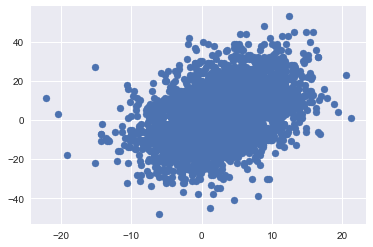

In [19]:
plt.scatter(y_train_pred, y_train)

Random Forest
(3635,)


0.499779047129


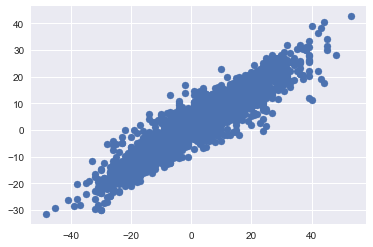

In [21]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor() # todo: hyperparameter search...

rf.fit(X_train, y_train.ravel())
print "Random Forest"
y_train_pred = rf.predict(X_train)
print fraction_correct(y_train_pred, y_train)
plt.scatter(y_train, y_train_pred)

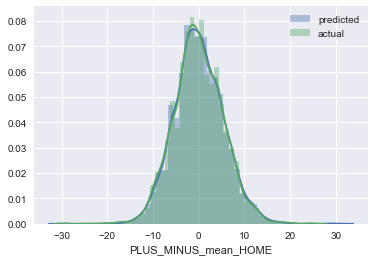

In [24]:
sns.distplot(df['PLUS_MINUS_mean_AWAY'].dropna(), label='predicted')
sns.distplot(df['PLUS_MINUS_mean_HOME'].dropna(), label='actual')
plt.legend()

In [428]:
# give a range which the prediction can be away from actual
def evaluate_prediction(y_pred,y_actual):
    
    delta = 10 # the range
    score = np.logical_and((y_pred < y_actual),\
    (y_pred > y_actual-delta)).astype(float)
    
    return sum(score)/len(score)
# evaluate_prediction(np.array([-1,-2,-5]),np.array([11,3,-10])) test

0.33333333333333331

In [425]:
import xgboost as xgb
from  functools import partial

dtrain = xgb.DMatrix(X_train,(y_train))
param = {'max_depth': 4, 'silent': 1}
num_round = 150

def learn_rate(n,t_n):
    return 1/(np.sqrt(n+.1))

def hinge(preds, dtrain):
    labels = dtrain.get_label()
    m = len(labels)
    a =  (labels <= preds).astype(int)
    # print preds
    # print(a[10:30])
    return a*np.ones(m), np.zeros(m)


def log(preds,dtrain):
    labels = dtrain.get_label()
    m = labels*preds
    return 1/(1+np.exp(m)) , 1/(np.exp(-m/2)+np.exp(m/2))**2

def softmax(preds,dtrain):
    labels = dtrain.get_label()
    m = labels - preds
    return 1/(np.exp(-m/2)+np.exp(m/2))**2, \
            2/(np.exp(-2*m/3)+np.exp(m/3))**3 \
                - 1/(np.exp(-m/2)+np.exp(m/2))**2

def skewed_sq(preds, dtrain,skewness,flat_region):
    labels = dtrain.get_label()
    b = skewness
    spread = flat_region
    a = (1)*(preds>labels) + \
            b*(preds<= labels-spread)
    return a*(preds - labels), a*np.ones(len(labels))

In [429]:
# finding optimal parameter
# for skew in [0.1,0.2,0.3]:
#     for flat in [3,4,5]:
#         skewed_sq = partial(skewed_sq,skewness = skew, flat_region = flat)
#         bst = xgb.train(params=param, dtrain=dtrain, num_boost_round=num_round, obj \
#                 = skewed_sq)
#         BT = bst.predict(xgb.DMatrix(X_val))
#         plt.scatter(BT,(y_val))
#         plt.plot(np.arange(-40,40),np.arange(-40,40),c = "y")
#         plt.show()
#         print "flat= ",flat,"skew= ",skew, evaluate_prediction(BT,y_val)

0.2877164056059357

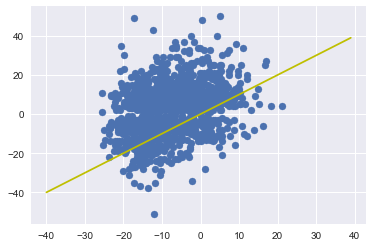

In [403]:
BT = bst.predict(xgb.DMatrix(X_val))
plt.scatter(BT,(y_val))
plt.plot(np.arange(-40,40),np.arange(-40,40),c = "y")
# fraction_correct(bst.predict(xgb.DMatrix(X_val)),(y_val))
evaluate_prediction(bst.predict(xgb.DMatrix(X_val)),y_val)

In [176]:
from sklearn.linear_model import LogisticRegression
LogR = LogisticRegression()
LogR.fit(X_train,np.sign(y_train).reshape(-1))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [171]:
np.array([LogR.predict(X_val) == np.sign(y_val)]).mean()

0.66859027205276178

c =  0.0015 0.687551525144


c =  0.002 0.684253915911


c =  0.0025 0.684253915911


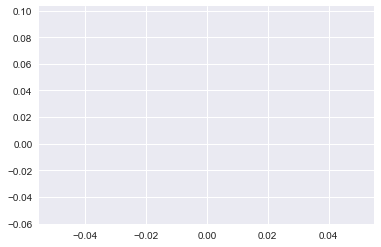

In [461]:
from sklearn.svm import LinearSVC as svm

for c in [0.0015,0.002,0.0025]:
    SVM = svm(C = c,penalty='l2',loss='hinge')
    SVM.fit(X_train,np.sign(y_train))
    print 'c = ',c, (SVM.predict(X_val) == np.sign(y_val)).astype(int).mean()


57


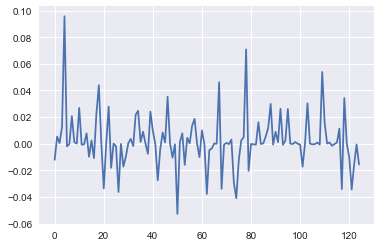

In [488]:
plt.plot(np.arange(0,len(SVM.coef_.reshape(-1)),1),SVM.coef_.reshape(-1))
# number of features that are zeros
print sum(SVM.coef_.reshape(-1) < 10**-5)

In [495]:
significant = np.where((np.abs(SVM.coef_.reshape(-1)) > 0.02))
print np.where((np.abs(SVM.coef_.reshape(-1)) > 0.02))
# the support vectors
len(significant[0])

(array([  4,   7,  10,  17,  18,  20,  22,  26,  33,  34,  39,  42,  46,
        50,  62,  67,  68,  73,  74,  78,  79,  88,  92,  95, 103, 109,
       117, 118, 121]),)


29

In [500]:
important_features = df_train[numerical_cols].keys()[significant[0]]
print important_features[important_features.str.contains("HOME")]
print important_features[important_features.str.contains("AWAY")]

Index([u'FTM_mean_HOME', u'FTA_mean_HOME', u'BLKA_mean_HOME',
       u'DREB_mean_HOME', u'OFF_RATING_mean_HOME', u'REB_mean_HOME',
       u'FGM_mean_HOME', u'PTS_2ND_CHANCE_mean_HOME', u'FG3M_mean_HOME',
       u'PACE_mean_HOME', u'OPP_PTS_FB_mean_HOME', u'PFD_mean_HOME',
       u'STL_mean_HOME', u'TOV_mean_HOME', u'AST_RATIO_mean_HOME',
       u'BLK_mean_HOME', u'BLK_mean_R_HOME', u'AST_mean_HOME',
       u'NET_RATING_mean_HOME'],
      dtype='object')
Index([u'BLKA_mean_AWAY', u'OPP_PTS_2ND_CHANCE_mean_AWAY', u'FGA_mean_AWAY',
       u'FTA_mean_AWAY', u'PTS_PAINT_mean_AWAY', u'PTS_FB_mean_AWAY',
       u'FG3A_mean_AWAY', u'PFD_mean_AWAY', u'FTM_mean_AWAY'],
      dtype='object')


In [560]:
from collections import Counter
games_wrong = df_val[(SVM.predict(X_val) != np.sign(y_val))]["MATCHUP_HOME"]
games_wrong_dict = games_wrong.to_dict()
for key,value in games_wrong_dict.items():
    games_wrong_dict[key] = value[0:3]
games_wrong_dict = Counter(games_wrong_dict).most_common()
dict = {}; temp = ''
for v,k in games_wrong_dict:
    if (temp != k):
        dict[k] = 0
        temp = k
    dict[temp] += 1
games_wrong_dict = dict

In [ ]:
games_right = df_val[(SVM.predict(X_val) == np.sign(y_val))]["MATCHUP_HOME"]
games_right_dict = games_right.to_dict()
for key,value in games_right_dict.items():
    games_right_dict[key] = value[0:3]
games_right_dict = Counter(games_right_dict).most_common()
dict = {}; temp = ''
for v,k in games_right_dict:
    if (temp != k):
        dict[k] = 0
        temp = k
    dict[temp] += 1
games_right_dict = dict

In [640]:
games_wrong_dict
sorted(games_wrong_dict.items(), key=lambda x: x[1],reverse=True)
sorted(games_right_dict.items(), key=lambda x: x[1],reverse=True)

[('SAS', 40),
 ('GSW', 38),
 ('PHI', 34),
 ('CLE', 32),
 ('TOR', 31),
 ('DAL', 31),
 ('OKC', 31),
 ('CHA', 30),
 ('MIA', 29),
 ('LAC', 29),
 ('ATL', 28),
 ('BOS', 28),
 ('BKN', 28),
 ('POR', 28),
 ('LAL', 28),
 ('MIL', 27),
 ('NYK', 27),
 ('UTA', 27),
 ('IND', 27),
 ('DET', 26),
 ('MEM', 26),
 ('PHX', 26),
 ('HOU', 24),
 ('MIN', 23),
 ('ORL', 23),
 ('CHI', 23),
 ('NOP', 23),
 ('DEN', 22),
 ('SAC', 21),
 ('WAS', 20)]

In [705]:
team_wrong = df_val[(SVM.predict(X_val) != np.sign(y_val))]["MATCHUP_HOME"]
ind_w = team_wrong[team_wrong.str[:3].str.contains("MIN")].index
WAS_im_features_w = df_val.ix[ind_w][important_features].as_matrix()

In [706]:
team_right = df_val[(SVM.predict(X_val) == np.sign(y_val))]["MATCHUP_HOME"]
ind_r = team_right[team_right.str[:3].str.contains("MIN")].index
WAS_im_features_r = df_val.ix[ind_r][important_features].as_matrix()

[4, 22, 39, 42, 109, 18]

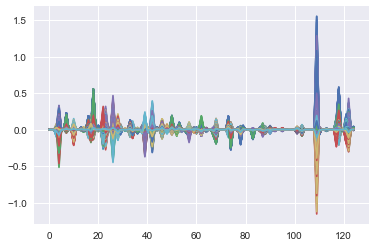

In [707]:
WAS_features_w = df_val[numerical_cols].ix[ind_w].as_matrix()
WAS_features_r = df_val[numerical_cols].ix[ind_r].as_matrix()

SVM_coef = SVM.coef_.reshape(-1)
feature_score_w = WAS_features_w*SVM_coef
feature_score_r = WAS_features_r*SVM_coef

counts = {}
for i in range(0,WAS_features_r.shape[0]):
    for j in range(0,WAS_features_w.shape[0]):
        plt.plot(feature_score_w[j,:]-feature_score_r[i,:])
        where = np.where(np.absolute(feature_score_w[j,:]-feature_score_r[i,:]) > 0.3)
        for k in range(0,len(where[0])):
           if where[0][k] not in counts.keys():
             counts[where[0][k]] = 1 
           else:
             counts[where[0][k]] +=1
counts
sorted(counts.items(), key=lambda x: x[1],reverse=True)
counts.keys()[0:6]

In [708]:
print important_features[important_features.str.contains("HOME")]
print important_features[important_features.str.contains("AWAY")]
df_val[numerical_cols].keys()[counts.keys()[0:6]]

Index([u'FTM_mean_HOME', u'FTA_mean_HOME', u'BLKA_mean_HOME',
       u'DREB_mean_HOME', u'OFF_RATING_mean_HOME', u'REB_mean_HOME',
       u'FGM_mean_HOME', u'PTS_2ND_CHANCE_mean_HOME', u'FG3M_mean_HOME',
       u'PACE_mean_HOME', u'OPP_PTS_FB_mean_HOME', u'PFD_mean_HOME',
       u'STL_mean_HOME', u'TOV_mean_HOME', u'AST_RATIO_mean_HOME',
       u'BLK_mean_HOME', u'BLK_mean_R_HOME', u'AST_mean_HOME',
       u'NET_RATING_mean_HOME'],
      dtype='object')
Index([u'BLKA_mean_AWAY', u'OPP_PTS_2ND_CHANCE_mean_AWAY', u'FGA_mean_AWAY',
       u'FTA_mean_AWAY', u'PTS_PAINT_mean_AWAY', u'PTS_FB_mean_AWAY',
       u'FG3A_mean_AWAY', u'PFD_mean_AWAY', u'FTM_mean_AWAY'],
      dtype='object')


Index([u'BLKA_mean_AWAY', u'FTA_mean_AWAY', u'PTS_FB_mean_AWAY',
       u'FG3A_mean_AWAY', u'AVG_SPREAD_mean', u'FTA_mean_HOME'],
      dtype='object')

In [688]:
X_train_less = df_train[numerical_cols][df_val[numerical_cols].keys()[counts.keys()[0:6]]].as_matrix()
X_val_less = df_val[numerical_cols][df_val[numerical_cols].keys()[counts.keys()[0:6]]].as_matrix()

SVM_less_features = svm(C=0.001,loss="hinge")
SVM_less_features.fit(X_train_less,np.sign(y_train))
(SVM_less_features.predict(X_val_less) != np.sign(y_val)).astype(float).mean()

0.32563891178895299

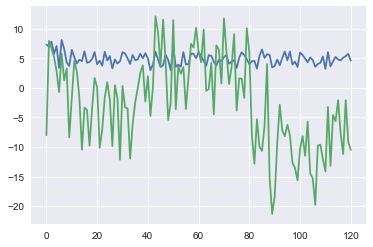

In [724]:
plt.plot(df_train[df_train["MATCHUP_HOME"].str[:3].str.contains("MIN")]["BLKA_mean_AWAY"].as_matrix()
         )
plt.plot(df_train[df_train["MATCHUP_HOME"].str[:3].str.contains("MIN")]["AVG_SPREAD_mean"].as_matrix()
         )

In [660]:
np.where(np.absolute(feature_score_w[0,:]-feature_score_r[5,:]) > 0.2)

(array([ 17,  18,  26,  74, 118, 121]),)

In [614]:
df_val.ix[ind].

,GAME_ID,GAME_DATE_HOME,MATCHUP_HOME,PLUS_MINUS_HOME,PLUS_MINUS_AWAY,TEAM_ID_HOME,TEAM_ABBREVIATION_HOME,TEAM_NAME_HOME,AST_mean_HOME,BLK_mean_HOME,...,PCT_PTS_FB_mean_AWAY,PCT_PTS_FT_mean_AWAY,PCT_PTS_OFF_TOV_mean_AWAY,PCT_PTS_PAINT_mean_AWAY,PCT_UAST_2PM_mean_AWAY,PCT_UAST_3PM_mean_AWAY,PCT_UAST_FGM_mean_AWAY,GAME_DATE,AVG_SPREAD_mean,ACTUAL_SPREAD
615,21500034,2015-10-31,WAS vs. NYK,-7,7,1610612764,WAS,Washington Wizards,21.000000,7.000000,...,0.162000,0.213000,0.177000,0.442500,0.522500,0.083500,0.438000,2015-10-31,-4.000000,-7
500,21500061,2015-11-04,WAS vs. SAS,3,-3,1610612764,WAS,Washington Wizards,19.666667,5.666667,...,0.069500,0.137000,0.123000,0.474750,0.515250,0.062500,0.446750,2015-11-04,-10.083333,3
838,21500139,2015-11-14,WAS vs. ORL,9,-9,1610612764,WAS,Washington Wizards,21.857143,5.142857,...,0.135900,0.155900,0.193000,0.422800,0.518600,0.102500,0.417400,2015-11-14,-8.742857,9
1017,21500158,2015-11-17,WAS vs. MIL,29,-29,1610612764,WAS,Washington Wizards,22.750000,5.250000,...,0.117900,0.190000,0.215400,0.463200,0.445900,0.064700,0.372400,2015-11-17,-2.300000,29
294,21500209,2015-11-24,WAS vs. IND,-17,17,1610612764,WAS,Washington Wizards,22.900000,4.500000,...,0.136846,0.169308,0.195231,0.360846,0.513462,0.104615,0.420000,2015-11-24,-6.853846,-17
600,21500269,2015-12-02,WAS vs. LAL,-4,4,1610612764,WAS,Washington Wizards,22.000000,4.133333,...,0.109765,0.199706,0.142529,0.365000,0.554882,0.163471,0.463647,2015-12-02,4.384314,-4
387,21500284,2015-12-04,WAS vs. PHX,3,-3,1610612764,WAS,Washington Wizards,22.125000,4.000000,...,0.152737,0.160947,0.164263,0.411947,0.578947,0.193474,0.478579,2015-12-04,-5.161184,3
700,21500321,2015-12-09,WAS vs. HOU,-6,6,1610612764,WAS,Washington Wizards,22.000000,3.578947,...,0.151545,0.206091,0.179591,0.422682,0.499000,0.208591,0.418636,2015-12-09,0.566986,-6
693,21500399,2015-12-19,WAS vs. CHA,8,-8,1610612764,WAS,Washington Wizards,22.583333,3.541667,...,0.088000,0.172520,0.165120,0.370240,0.518240,0.150840,0.416680,2015-12-19,-8.910000,8
474,21500410,2015-12-21,WAS vs. SAC,14,-14,1610612764,WAS,Washington Wizards,22.720000,3.560000,...,0.167037,0.166593,0.174593,0.461963,0.452667,0.120778,0.381444,2015-12-21,-1.943704,14
